<a href="https://colab.research.google.com/github/SidU/LLMs-from-scratch/blob/main/LogProbIntuition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Why Use Log Instead of Probabilities?**
### **Overview**
In language models like GPT, the model **learns by maximizing the probability of an entire sequence**.  
It does this by **predicting one token at a time**, assigning probabilities, and adjusting its parameters to increase the likelihood of correct sequences.  

The total probability of a sequence is computed as:

$
P(\text{"The cat sat on the mat"}) =
P(\text{"The"}) \times
P(\text{"cat"} | \text{"The"}) \times
P(\text{"sat"} | \text{"The cat"}) \times
P(\text{"on"} | \text{"The cat sat"}) \times
P(\text{"the"} | \text{"The cat sat on"}) \times
P(\text{"mat"} | \text{"The cat sat on the"})
$

However, **multiplying probabilities causes numerical instability** because probabilities are small numbers between 0 and 1, and their product shrinks exponentially.  
Instead, we use **log-probabilities**, which turn multiplication into addition, making calculations more stable and preventing numerical underflow.

This notebook explains:  
✅ **Why sequence probability matters in training, generation, and evaluation.**  
✅ **Why we multiply probabilities in sequence models.**  
✅ **Why multiplying directly is problematic.**  
✅ **How using log-probabilities solves these issues.**  
✅ **How this connects to Cross-Entropy Loss in GPT.**  

By the end, you’ll understand why **log-probabilities make training large language models stable and efficient**. 🚀  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

## **📌 Why Do We Multiply Probabilities?**
In **language modeling**, we predict **each token in a sequence independently**, assigning a probability to each.

The **total probability of a sequence** is the **joint probability of all tokens occurring together**, which is computed by **multiplying individual token probabilities**:


$
P(\text{sentence}) = P(w_1) \times P(w_2 | w_1) \times P(w_3 | w_1, w_2) \times \dots
$

This means that as the sequence grows, **the total probability rapidly shrinks**.


# Why directly multiplying probablities is problematic


In [2]:
# Define probabilities of correct predictions for different tokens in a sequence
probabilities = [0.9, 0.7, 0.6, 0.1]  # Example sequence of token probabilities

# Compute the total probability (product of all probabilities)
total_prob = np.prod(probabilities)

print("Total Probability:", total_prob)

Total Probability: 0.0378


* The probability shrinks exponentially when multiplied over long sequences.
* This makes calculations unstable, leading to numerical underflow.

# Fixing the issue with Log Probabilities

In [3]:
# Compute log-probabilities (sum instead of product)
log_probabilities = np.log(probabilities)
total_log_prob = np.sum(log_probabilities)

print("Log Probabilities:", log_probabilities)
print("Total Log Probability:", total_log_prob)

Log Probabilities: [-0.10536052 -0.35667494 -0.51082562 -2.30258509]
Total Log Probability: -3.2754461763565947


* Instead of multiplying probabilities, we sum their logs.
* This prevents extremely small numbers and makes optimization numerically stable.

# Visualizing probability vs negative log probability

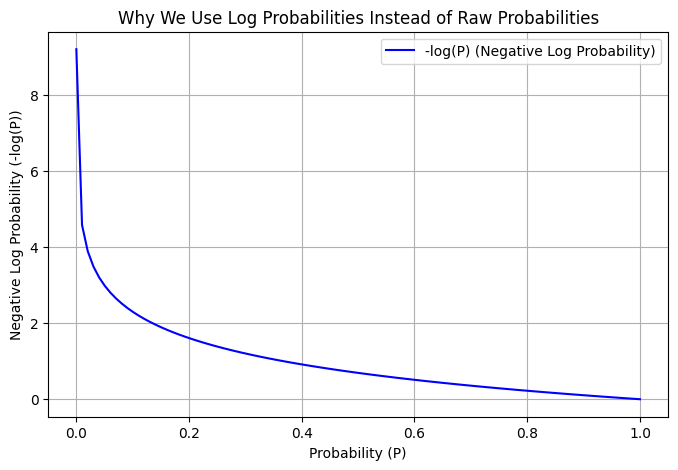

In [4]:
# Define a range of probability values
probs = np.linspace(0.0001, 1, 100)
neg_log_probs = -np.log(probs)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(probs, neg_log_probs, label="-log(P) (Negative Log Probability)", color="blue")
plt.xlabel("Probability (P)")
plt.ylabel("Negative Log Probability (-log(P))")
plt.title("Why We Use Log Probabilities Instead of Raw Probabilities")
plt.legend()
plt.grid(True)
plt.show()


* Lower probability = higher penalty (steep slope).
* Higher probability = smaller penalty, which encourages confident predictions.

# How this applies to cross-entropy loss

In [5]:
# Example logits from a model (before softmax)
logits = torch.tensor([[2.5, 1.0, -0.5]])  # 3 classes

# Convert logits to probabilities using softmax
probs = F.softmax(logits, dim=-1)

# Compute negative log probabilities (NLL loss for each class)
log_probs = -torch.log(probs)

# True class index (assume class 0 is the correct answer)
true_class_index = torch.tensor([0])

# Compute Cross-Entropy Loss (softmax + NLL in one step)
loss = F.cross_entropy(logits, true_class_index)

print("Softmax Probabilities:", probs)
print("Negative Log Probabilities:", log_probs)
print("Cross-Entropy Loss:", loss.item())


Softmax Probabilities: tensor([[0.7856, 0.1753, 0.0391]])
Negative Log Probabilities: tensor([[0.2413, 1.7413, 3.2413]])
Cross-Entropy Loss: 0.24131132662296295



* **Cross-Entropy Loss = Negative Log Probability of the Correct Token.**
* The model is **penalized more when it assigns low probability** to the correct class.
* Using logs makes **optimization smooth** and prevents numerical underflow.

💡 **But Cross-Entropy Loss is not always intuitive—this is where Perplexity helps.**
* **Perplexity = $ e^{\text{Cross-Entropy Loss}} $** gives a more interpretable score.
* Perplexity tells us **how many equally likely tokens the model is choosing between**.
* If **Perplexity = 1**, the model is **100% confident** in the correct token.
* If **Perplexity = 5**, the model is **choosing between 5 likely words**.
* If **Perplexity = 100+,** the model is struggling to make a confident choice.

✅ **Lower Perplexity = More Confident Predictions.**

✅ **This makes it easier to understand how well the model is performing.**



In [7]:
import torch
import torch.nn.functional as F

# Example logits from a model (before softmax)
logits = torch.tensor([[2.5, 1.0, -0.5]])  # 1 token, 3 possible vocabulary words

# Convert logits to probabilities using softmax
probs = F.softmax(logits, dim=-1)

# Compute negative log probabilities (NLL loss for each class)
log_probs = -torch.log(probs)

# True class index (assume class 0 is the correct answer)
true_class_index = torch.tensor([0])

# Compute Cross-Entropy Loss (softmax + NLL in one step)
loss = F.cross_entropy(logits, true_class_index)

# Compute Perplexity (exponentiate Cross-Entropy Loss)
perplexity = torch.exp(loss)

# Print results with explanation
print("Softmax Probabilities:", probs.numpy())
print("Negative Log Probabilities:", log_probs.numpy())
print("Cross-Entropy Loss:", loss.item())
print("Perplexity:", perplexity.item())

# Interpretation of perplexity
if perplexity.item() < 2:
    print("\n✅ The model is highly confident in the correct token choice.")
elif perplexity.item() < 10:
    print("\n⚠️ The model is uncertain but somewhat confident.")
else:
    print("\n❌ The model is struggling, considering many possible tokens.")


Softmax Probabilities: [[0.785597   0.17529039 0.03911257]]
Negative Log Probabilities: [[0.24131131 1.7413113  3.2413113 ]]
Cross-Entropy Loss: 0.24131132662296295
Perplexity: 1.2729172706604004

✅ The model is highly confident in the correct token choice.


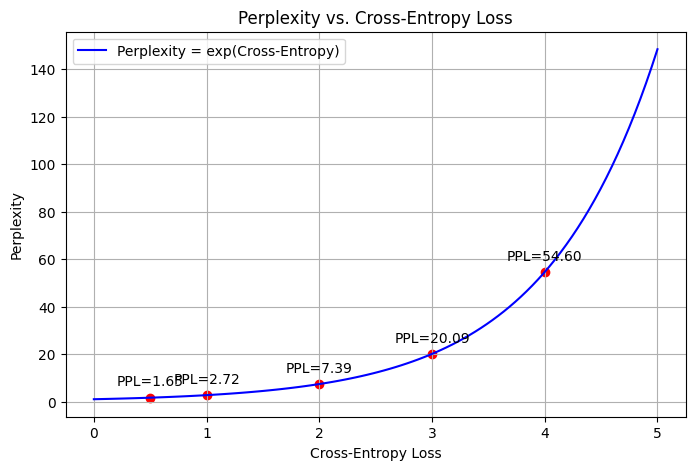

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of Cross-Entropy Loss values
cross_entropy_values = np.linspace(0, 5, 100)  # Simulating different loss values
perplexity_values = np.exp(cross_entropy_values)  # Compute perplexity

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(cross_entropy_values, perplexity_values, label="Perplexity = exp(Cross-Entropy)", color="blue")

# Highlight key points for interpretability
highlight_points = [0.5, 1.0, 2.0, 3.0, 4.0]
for point in highlight_points:
    plt.scatter(point, np.exp(point), color='red')  # Mark points on the curve
    plt.text(point, np.exp(point) + 5, f"PPL={np.exp(point):.2f}", fontsize=10, ha="center")

# Labels and title
plt.xlabel("Cross-Entropy Loss")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Cross-Entropy Loss")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


## **How to Interpret This?**
- **Low Cross-Entropy Loss (0.5 - 1.0) → Low Perplexity (~1-3)**  
  ✅ The model is highly confident, selecting the correct token with high probability.  

- **Medium Cross-Entropy Loss (2.0 - 3.0) → Moderate Perplexity (~7-20)**  
  ⚠️ The model is uncertain, choosing between **7-20** likely tokens.  

- **High Cross-Entropy Loss (4.0 - 5.0) → High Perplexity (~55-150)**  
  ❌ The model is struggling, considering a very large number of possible tokens.  
